In [67]:
import sys
sys.path.insert(1, '/home/glenn/src/latent_ode/')
from generate_timeseries import *
import pdb

In [50]:
from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
%matplotlib inline

In [4]:
init = 0
# final = 1

In [5]:
tmax = 500
tmin = 0
xs = np.arange(tmin, tmax)

In [6]:
ts = np.sort(np.random.choice(xs, 100))

In [7]:
ts

array([  0,   4,   5,   7,   7,   8,  12,  18,  33,  37,  39,  43,  53,
        57,  61,  72,  72,  75,  81,  86,  94,  95,  95, 109, 109, 109,
       113, 116, 124, 127, 127, 132, 133, 136, 143, 149, 150, 152, 153,
       156, 160, 168, 168, 172, 174, 183, 184, 185, 187, 187, 192, 206,
       214, 214, 217, 218, 230, 234, 236, 237, 249, 254, 256, 257, 257,
       260, 262, 273, 278, 287, 289, 293, 294, 309, 310, 311, 313, 321,
       321, 335, 339, 354, 364, 368, 368, 370, 384, 385, 404, 429, 432,
       435, 452, 464, 475, 479, 480, 486, 492, 496])

In [8]:
generate_periodic(xs[0:1], init_freq=0.1, init_amplitude=init, starting_point=0, phi_offset=0.)

array([[0., 0.]])

In [9]:
f = Periodic_1d()

In [24]:
x = f.sample_traj(ts)
x_np = x.squeeze().detach().cpu().numpy()

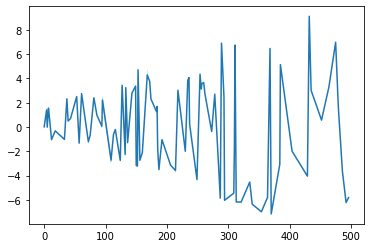

In [25]:
sns.lineplot(x=ts, y=x_np)

In [32]:
l = int(x.size(1)*0.8)

In [14]:
x_train = x[0][:l]
x_test = x[0][l:]

In [30]:
ts = torch.Tensor(ts)

In [31]:
ts.shape

torch.Size([100])

In [34]:
ts_train = ts[:l]
ts_test = ts[l:]

In [35]:
ts_test

tensor([339., 354., 364., 368., 368., 370., 384., 385., 404., 429., 432., 435.,
        452., 464., 475., 479., 480., 486., 492., 496.])

In [98]:
dataset = f.sample_traj(ts, n_samples = 32, noise_weight = 0.2)

In [99]:
dataset.shape

torch.Size([32, 100, 1])

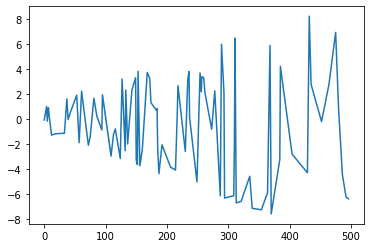

In [39]:
sns.lineplot(x=ts, y=dataset[10].squeeze().numpy())

In [97]:
dataset.shape

torch.Size([32, 100, 1])

In [101]:
L = 80

In [100]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, xs):
        self.xs = xs

    def __getitem__(self, i):
        x = self.xs[i]
        return x
    
    def __len__(self):
        return len(self.xs)

In [109]:
ix = int(0.8*len(dataset))
train_ds = TSDataset(dataset[:ix])
test_ds = TSDataset(dataset[ix:])

In [113]:
def collate_fn(batch):
    batch = torch.stack(batch)
    pdb.set_trace()
    inps = batch[:, :L, :]
    outps = batch[:, L:, :]
    return inps, outps

In [114]:
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=len(x_test), collate_fn=collate_fn)

In [115]:
a = next(iter(train_loader))

> <ipython-input-113-911aa524a8c5>(4)collate_fn()
-> inps = batch[:, :L, :]
(Pdb) p batch.shape
torch.Size([4, 100, 1])
(Pdb) n
> <ipython-input-113-911aa524a8c5>(5)collate_fn()
-> outps = batch[:, L:, :]
(Pdb) n
> <ipython-input-113-911aa524a8c5>(6)collate_fn()
-> return inps, outps
(Pdb) c


In [117]:
xs, ys = a

In [120]:
ys[0].shape

torch.Size([20, 1])